# DS 100 Final Project - Estimating Covid-19 Deaths by Counties

By Sunny Shen, Jerome Chen, and Olivia Zhang

In [957]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

# 1. EDA and Data Cleaning

## 1.1 Clean Abridged_counties Data

In [958]:
abridged_couties = pd.read_csv('abridged_couties.csv')
abridged_couties.head()

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
0,01001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,NaN,NaN,NaN
1,01003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,NaN,NaN,NaN
2,01005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,6.08,5400.0,18241.0
3,01007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,2.75,14980.0,6120.0
4,01009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4242,7.21,31850.0,25233.0


In [959]:
abridged_couties.shape

(3244, 87)

In [960]:
abridged_couties.isna().sum().sort_values().head(10)

countyFIPS           0
CountyName           0
StateName            0
PopMale5-92010      19
PopFmle5-92010      19
PopMale10-142010    19
PopFmle10-142010    19
PopMale15-192010    19
PopFmle15-192010    19
PopFmle20-242010    19
dtype: int64

Only 3 columns have non null values. There are null values in column state. Therefore, we import states.csv in order to fill in the Nah values of column "State" in Abridged counties

In [961]:
state_name = pd.read_csv('states.csv')
state_name = state_name.append({'State':'Puerto Rico', 'Abbreviation':'PR'},ignore_index=True)

In [962]:
#fill in rows that have "State" as NaN
clean_counties = pd.merge(left=abridged_couties, right=state_name, 
                           left_on='StateName',right_on='Abbreviation',
                           how='left').drop(['StateName','State_x'],axis=1)
clean_counties = clean_counties.rename(columns={'State_y':'State'})
clean_counties = clean_counties[clean_counties['State'].isnull()==False]
#right now, all State & State Abbreviation are not null

In [963]:
clean_counties['countyFIPS'] = clean_counties['countyFIPS'].astype(str)

In [964]:
len(clean_counties['State'].unique()) #There're 52 states

52

In [965]:
pd.DataFrame(clean_counties.isna().sum().sort_values(ascending=False)).head(20)

,0
3-YrMortalityAge1-4Years2015-17,3165
mortality2015-17Estimated,3135
3-YrMortalityAge5-14Years2015-17,3135
3-YrMortalityAge<1Year2015-17,2760
3-YrMortalityAge15-24Years2015-17,2599
3-YrMortalityAge25-34Years2015-17,2259
3-YrMortalityAge35-44Years2015-17,1906
3-YrDiabetes2015-17,1734
HPSAUnderservedPop,1141
HPSAServedPop,1141


There are large amount of null values in columns of information about 3-year mortality, and there're also a lot of null values in columns of inofrmation about hopsital shortage. For those columns, it doesn't make sense to fill them with national averae, so we will drop them later on (after we get the final merged dataframe)

## 1.2 Clean Deaths by County Data

In [966]:
county_death = pd.read_csv('us-counties.csv')
print('This table has data for', len(county_death['state'].unique()), 'different states')

This table has data for 55 different states


In [967]:
county_death.isna().sum()

date         0
county       0
state        0
fips      1372
cases        0
deaths       0
dtype: int64

In [968]:
county_death[county_death['fips'].isnull()]

,date,county,state,fips,cases,deaths
416,2020-03-01,New York City,New York,NaN,1,0
418,2020-03-01,Unknown,Rhode Island,NaN,2,0
448,2020-03-02,New York City,New York,NaN,1,0
450,2020-03-02,Unknown,Rhode Island,NaN,2,0
482,2020-03-03,New York City,New York,NaN,2,0
...,...,...,...,...,...,...
117591,2020-05-05,Unknown,Rhode Island,NaN,1414,36
118015,2020-05-05,Unknown,Utah,NaN,0,3
118031,2020-05-05,Unknown,Vermont,NaN,4,0
118035,2020-05-05,Unknown,Virgin Islands,NaN,66,4


the rows with null FIPS column also have “unknown” as county names. Therefore we cannot know which county the rows refer to, so we drop the rows with “Unknown” in the county column. We name the dataframe clean_death afterwards.

In [969]:
#use the most updated data -- May 5th
clean_death = county_death[county_death['date']=='2020-05-05']
#drop all counties that are "Unknown"
clean_death = clean_death[clean_death['county']!='Unknown']

#NYC and Kansas are special (see https://github.com/nytimes/covid-19-data)

clean_death = clean_death.fillna(0) #fill fips for NYC and Kansas
clean_death['fips'] = clean_death['fips'].astype(int).astype(str)

In [970]:
merge_county_deaths = pd.merge(left=clean_counties, right=clean_death,
                               left_on='countyFIPS',right_on='fips')

In [971]:
#merge county demographic features & county deaths
#NYC and Kansas are unique cases, they're left out in this table becuase it was inner merge
merge_county_deaths.head()

,countyFIPS,STATEFP,COUNTYFP,CountyName,lat,lon,POP_LATITUDE,POP_LONGITUDE,CensusRegionName,CensusDivisionName,...,HPSAServedPop,HPSAUnderservedPop,State,Abbreviation,date,county,state,fips,cases,deaths
0,10001,10.0,1.0,Kent,39.087654,-75.573876,39.123220,-75.558604,South,South Atlantic,...,0.0,52966.0,Delaware,DE,2020-05-05,Kent,Delaware,10001,847,32
1,10003,10.0,3.0,New Castle,39.583358,-75.655191,39.685020,-75.634376,South,South Atlantic,...,NaN,NaN,Delaware,DE,2020-05-05,New Castle,Delaware,10003,1979,83
2,10005,10.0,5.0,Sussex,38.665735,-75.406689,38.662387,-75.346649,South,South Atlantic,...,0.0,65373.0,Delaware,DE,2020-05-05,Sussex,Delaware,10005,2520,72
3,11001,11.0,1.0,Washington,38.910787,-77.034099,38.910270,-77.014468,South,South Atlantic,...,NaN,NaN,District of Columbia,DC,2020-05-05,District of Columbia,District of Columbia,11001,5322,264
4,12001,12.0,1.0,Alachua,29.669178,-82.357751,29.665903,-82.386845,South,South Atlantic,...,12780.0,89514.0,Florida,FL,2020-05-05,Alachua,Florida,12001,289,5


In [972]:
merge_county_deaths.shape

(2572, 93)

In [973]:
# we drop columns that either have way too many null values or aren't useful to our project (like latitude/longitude)

useful_col = merge_county_deaths.drop(['STATEFP', 'COUNTYFP','lat', 'lon',
       'POP_LATITUDE', 'POP_LONGITUDE', 'CensusRegionName','PopTotalMale2017', 'PopTotalFemale2017',
       'FracMale2017',
       'CensusDivisionName', 'Rural-UrbanContinuumCode2013','date','county','state','fips'
                          ,'3-YrMortalityAge<1Year2015-17',
       '3-YrMortalityAge1-4Years2015-17', '3-YrMortalityAge5-14Years2015-17',
       '3-YrMortalityAge15-24Years2015-17',
       '3-YrMortalityAge25-34Years2015-17',
       '3-YrMortalityAge35-44Years2015-17',
       '3-YrMortalityAge45-54Years2015-17',
       '3-YrMortalityAge55-64Years2015-17',
       '3-YrMortalityAge65-74Years2015-17',
       '3-YrMortalityAge75-84Years2015-17', '3-YrMortalityAge85+Years2015-17','3-YrDiabetes2015-17',
        'HPSAShortage', 'HPSAServedPop', 'HPSAUnderservedPop','Abbreviation','mortality2015-17Estimated'],axis=1)
cols = useful_col.columns.to_list()

In [974]:
useful_col.shape

(2572, 60)

Text(0.5, 1.0, 'Number of null values in useful_col')

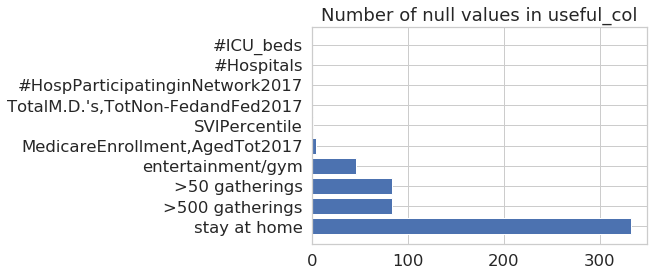

In [975]:
null = pd.DataFrame(useful_col.isna().sum().sort_values(ascending=False)).head(10)
plt.barh(null.index, null[0])
plt.title('Number of null values in useful_col')

We explore the null values in the dataframe useful_col, and we find that there are still null values of policy columns like “stay at home”, “>500 gaterings”, “>50 gatherings”, etc. After some online research we find out that for counties that have null values in those columns, they do not have those policies restricting people’s activities in their counties, and therefore we wiill fill the values with the ordinal numbers of today’s date, assuming the dates of the start of the policies would have an impact on deaths (this happens later on in the notebook)


In [976]:
#just change the column order so that it's easier to read

re_col = cols[:2] + cols[-3:] + cols[2:-3]
re_col_dt = useful_col[re_col]
re_col_dt.head()

,countyFIPS,CountyName,State,cases,deaths,PopulationEstimate2018,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,...,PopFmle>842010,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile
0,10001,Kent,Delaware,847,32,178550.0,29407.0,276.9,162310.0,36.6,...,1643.0,737508.0,737508.0,737508.0,737500.0,737496.0,737496.0,737500.0,737495.0,0.7268
1,10003,New Castle,Delaware,1979,83,559335.0,84505.0,1263.2,538479.0,37.2,...,6204.0,737508.0,737508.0,737508.0,737500.0,737496.0,737496.0,737500.0,737495.0,0.3761
2,10005,Sussex,Delaware,2520,72,229286.0,60216.0,210.6,197145.0,45.4,...,2783.0,737508.0,737508.0,737508.0,737500.0,737496.0,737496.0,737500.0,737495.0,0.4019
3,11001,Washington,District of Columbia,5322,264,702455.0,83734.0,9856.5,601723.0,33.8,...,7198.0,737516.0,737509.0,737509.0,737500.0,737500.0,737500.0,737500.0,737495.0,0.5965
4,12001,Alachua,Florida,289,5,269956.0,36299.0,282.7,247336.0,30.1,...,2427.0,737509.0,737501.0,737501.0,737500.0,737504.0,737504.0,737500.0,737495.0,0.4729


## 1.3 Clean poverty data

In [977]:
PovertyEstimates = pd.read_csv('PovertyEstimates.csv')

In [978]:
poverty = PovertyEstimates[['countyFIPS','Poverty Pct All Ages 2018','Median Household Income 2018']]
poverty['countyFIPS'] = poverty['countyFIPS'].astype(str)
poverty.head()

,countyFIPS,Poverty Pct All Ages 2018,Median Household Income 2018
0,1001,13.8,59338
1,1003,9.8,57588
2,1005,30.9,34382
3,1007,21.8,46064
4,1009,13.2,50412


In [979]:
pov_death_county = pd.merge(left=re_col_dt,right = poverty, on='countyFIPS',how='left')
pov_death_county.head()

,countyFIPS,CountyName,State,cases,deaths,PopulationEstimate2018,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,...,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,Poverty Pct All Ages 2018,Median Household Income 2018
0,10001,Kent,Delaware,847,32,178550.0,29407.0,276.9,162310.0,36.6,...,737508.0,737508.0,737500.0,737496.0,737496.0,737500.0,737495.0,0.7268,13.8,54980
1,10003,New Castle,Delaware,1979,83,559335.0,84505.0,1263.2,538479.0,37.2,...,737508.0,737508.0,737500.0,737496.0,737496.0,737500.0,737495.0,0.3761,11.6,69562
2,10005,Sussex,Delaware,2520,72,229286.0,60216.0,210.6,197145.0,45.4,...,737508.0,737508.0,737500.0,737496.0,737496.0,737500.0,737495.0,0.4019,12.3,59821
3,11001,Washington,District of Columbia,5322,264,702455.0,83734.0,9856.5,601723.0,33.8,...,737509.0,737509.0,737500.0,737500.0,737500.0,737500.0,737495.0,0.5965,16.1,82533
4,12001,Alachua,Florida,289,5,269956.0,36299.0,282.7,247336.0,30.1,...,737501.0,737501.0,737500.0,737504.0,737504.0,737500.0,737495.0,0.4729,19.8,51026


In [980]:
pov_death_county.isna().sum().sort_values(ascending=False)

stay at home                      333
>50 gatherings                     83
>500 gatherings                    83
entertainment/gym                  46
MedicareEnrollment,AgedTot2017      4
                                 ... 
PopMale25-292010                    0
PopFmle20-242010                    0
PopMale20-242010                    0
Poverty Pct All Ages 2018           0
countyFIPS                          0
Length: 62, dtype: int64

In [981]:
pov_death_county[pov_death_county['>50 gatherings'].isnull()][['CountyName',
                                                             'State','stay at home']]['State'].value_counts()
#North Dakota, Nebraska, Iowa and Arkansas are the only states where no one is under a stay-at-home order.
#assume the nan values mean that the counties don't haave stay at home order -- we can fill the NaN with today's date

South Dakota    46
North Dakota    37
Name: State, dtype: int64

Based on previous reasoning, counties that have null values in those columns, they do not have those policies restricting people’s activities in their counties, so we fill the values with the ordinal numbers of today’s date, assuming the dates of the start of the policies would have an impact on deaths.

In [982]:
may7= pd.to_datetime('today').toordinal() #todays date in ordinal

In [983]:
fill_with_date = {'stay at home': pd.to_datetime('today').toordinal(),
                  '>50 gatherings': pd.to_datetime('today').toordinal(),
                 '>500 gatherings':pd.to_datetime('today').toordinal(),
                 'entertainment/gym':pd.to_datetime('today').toordinal()}
pov_death_county = pov_death_county.fillna(fill_with_date)

In [984]:
pov_death_county.isna().sum().sort_values(ascending=False).head(20)

MedicareEnrollment,AgedTot2017      4
SVIPercentile                       1
Median Household Income 2018        0
Smokers_Percentage                  0
PopMale10-142010                    0
PopFmle5-92010                      0
PopMale5-92010                      0
PopFmle<52010                       0
PopMale<52010                       0
dem_to_rep_ratio                    0
#ICU_beds                           0
#Hospitals                          0
#HospParticipatinginNetwork2017     0
TotalM.D.'s,TotNon-FedandFed2017    0
#FTEHospitalTotal2017               0
RespMortalityRate2014               0
HeartDiseaseMortality               0
StrokeMortality                     0
PopMale15-192010                    0
DiabetesPercentage                  0
dtype: int64

In [985]:
#fill in medicare enrollment by estimating the overall percentage of people in medicare throughout the country
medicare_perc = sum(pov_death_county['MedicareEnrollment,AgedTot2017'].fillna(0))/sum(pov_death_county['PopulationEstimate2018'])

#index of null medicare
index= pov_death_county[pov_death_county['MedicareEnrollment,AgedTot2017'].isnull()].index
#fill in values = pop * %of people in medicare
for x in index:
    pov_death_county.loc[x, 'MedicareEnrollment,AgedTot2017'] = medicare_perc * pov_death_county.loc[x, 'PopulationEstimate2018']

In [986]:
#fill in nan values for SVIPercentile column with the nation average
index2= pov_death_county[pov_death_county['SVIPercentile'].isnull()].index
pov_death_county.loc[index2, 'SVIPercentile'] = np.mean(pov_death_county['SVIPercentile'].fillna(0))

In [987]:
pov_death_county.isnull().sum().sort_values(ascending=False)
#NO MORE NAN VALUES

Median Household Income 2018    0
Smokers_Percentage              0
PopFmle10-142010                0
PopMale10-142010                0
PopFmle5-92010                  0
                               ..
PopFmle30-342010                0
PopMale30-342010                0
PopFmle25-292010                0
PopMale25-292010                0
countyFIPS                      0
Length: 62, dtype: int64

In [988]:
pov_death_county.head()

,countyFIPS,CountyName,State,cases,deaths,PopulationEstimate2018,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,...,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,Poverty Pct All Ages 2018,Median Household Income 2018
0,10001,Kent,Delaware,847,32,178550.0,29407.0,276.9,162310.0,36.6,...,737508.0,737508.0,737500.0,737496.0,737496.0,737500.0,737495.0,0.7268,13.8,54980
1,10003,New Castle,Delaware,1979,83,559335.0,84505.0,1263.2,538479.0,37.2,...,737508.0,737508.0,737500.0,737496.0,737496.0,737500.0,737495.0,0.3761,11.6,69562
2,10005,Sussex,Delaware,2520,72,229286.0,60216.0,210.6,197145.0,45.4,...,737508.0,737508.0,737500.0,737496.0,737496.0,737500.0,737495.0,0.4019,12.3,59821
3,11001,Washington,District of Columbia,5322,264,702455.0,83734.0,9856.5,601723.0,33.8,...,737509.0,737509.0,737500.0,737500.0,737500.0,737500.0,737495.0,0.5965,16.1,82533
4,12001,Alachua,Florida,289,5,269956.0,36299.0,282.7,247336.0,30.1,...,737501.0,737501.0,737500.0,737504.0,737504.0,737500.0,737495.0,0.4729,19.8,51026


In [989]:
pov_death_county.shape

(2572, 62)

In [990]:
#change all the percentage data into counts of ___(smokers/diabetes/poverty). 
#Becuase here we're estimating death counts not death rates

pov_death_county['Smokers'] = pov_death_county['Smokers_Percentage'] * pov_death_county['PopulationEstimate2018']/100
pov_death_county['Diabetes'] = pov_death_county['DiabetesPercentage'] *pov_death_county['PopulationEstimate2018']/100
pov_death_county['Poverty'] = pov_death_county['Poverty Pct All Ages 2018']*pov_death_county['PopulationEstimate2018']/100

pov_death_county = pov_death_county.drop(['Smokers_Percentage','DiabetesPercentage','Poverty Pct All Ages 2018'],axis=1)


In [991]:
pov_death_county.shape

(2572, 62)

In [992]:
# END OF DATA CLEANING

## 1.4 Some scatterplots to plot relationship between death counts and some features

Intuitively, we think that there may be a positive relationship between deaths and features like number of confirmed cases, number of older people, or number of people living in poverty. There may be a negative relationship between deaths and features like number of hospitals, median income. Here are some scatter plots exploring the relationship among features.


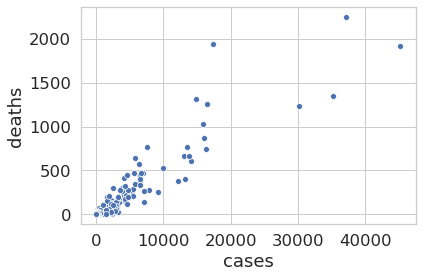

In [993]:
sns.scatterplot('cases', 'deaths',data=pov_death_county )

Text(0.5, 0, 'Population of Female older than 84')

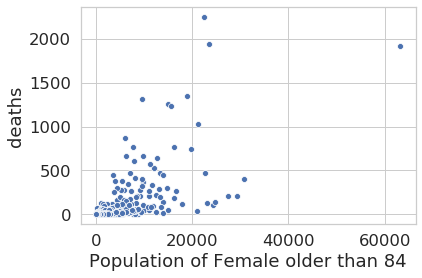

In [994]:
sns.scatterplot('PopFmle>842010', 'deaths',data=pov_death_county)
plt.xlabel('Population of Female older than 84')

Text(0.5, 0, 'Population of male older than 84')

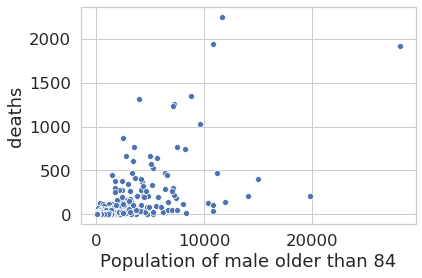

In [995]:
sns.scatterplot('PopMale>842010', 'deaths',data=pov_death_county)
plt.xlabel('Population of male older than 84')

Text(0.5, 0, 'Number of people living in poverty')

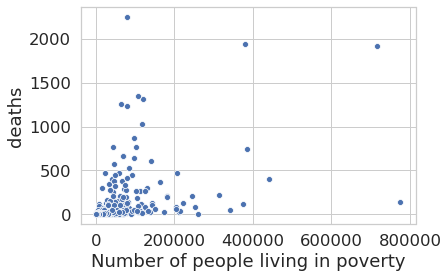

In [996]:
sns.scatterplot('Poverty', 'deaths',data=pov_death_county)
plt.xlabel('Number of people living in poverty')

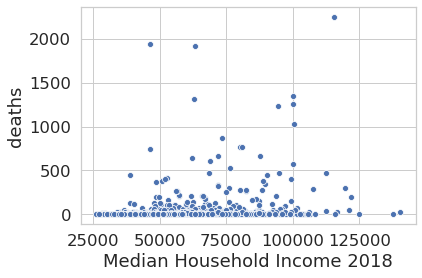

In [997]:
sns.scatterplot('Median Household Income 2018', 'deaths',data=pov_death_county)

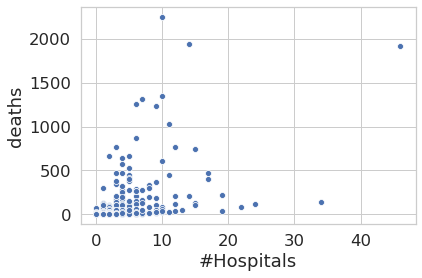

In [998]:
sns.scatterplot('#Hospitals', 'deaths',data=pov_death_county)

While there seems to be a linear relationship between cases and deaths, between the older population and deaths, between people living in poverty and deaths, we don’t see an obvious relationship between median income and death. While we expected to see a negative relationship between the number of hospitals and deaths because there are more medical resources, there seems to be a slightly positive relationship. One explanation could be that counties with large numbers of hospitals also have a large population, so there may be more deaths in those counties.

In [999]:
## a function to compare models


def compare_models(models):
    # training error for each model
    training_rmse = [rmse_score(model, train, Y_train) for model in models.values()]
    # cross validation error for each model
    validation_rmse = [np.mean(cross_val_score(model, train, Y_train, scoring=rmse_score, cv=5)) 
                       for model in models.values()]
    
    #x_pos = [i for i, _ in enumerate(models.keys())]

    ind = np.arange(len(models)) 
    width = 0.2
    #names = list(models.keys())
    
    fig, ax = plt.subplots(figsize=(10, 5))

    
    plt.bar(ind,training_rmse,width, label='Train RMSE' )
    plt.bar(ind+width, validation_rmse, width, label='CV RMSE')
    
    
    plt.xticks(ind + width / 2, models.keys())
    plt.legend(loc='best')
    plt.show()
    
    #print(training_rmse)

# 2 Modeling

In [1000]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import f_regression

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge

In [1001]:
#models
models = {}

## 2.1 Train/Test Split

In [1002]:
train, test = train_test_split(pov_death_county, test_size=0.2, random_state=83)

In [1003]:
Y_train = train.iloc[:,4]
Y_test = test.iloc[:,4]

In [1004]:
final_col = pov_death_county.columns.to_list()
X_col = [final_col[3]]+final_col[5:62]
X_train = train[X_col]
X_test = test[X_col]

In [1005]:
len(X_col)

58

In [1006]:
from sklearn.preprocessing import StandardScaler
X_train_norm = StandardScaler().fit_transform(X_train)

## 2.2 Linear Model without Regularization

In [1007]:
lin_model = Pipeline([
        ("SelectColumns", ColumnTransformer([
            ("keep", StandardScaler(), X_col),
        ])),
        ("LinearModel", LinearRegression())
    ])

lin_model.fit(train,Y_train)
lin_model.predict(train)

array([171.44446487,  -3.98959251,  -1.33343444, ..., 203.32753773,
        -3.94721836,  -4.52072569])

In [1008]:
def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

In [1009]:
print("Training Error (RMSE):", rmse(Y_train, lin_model.predict(train)))

Training Error (RMSE): 28.032548068290136


In [1010]:
def rmse_score(model, X, y):
    return np.sqrt(np.mean((y - model.predict(X))**2))

In [1011]:
print("CV Error (RMSE):",np.mean(cross_val_score(lin_model, train, Y_train, scoring=rmse_score, cv=5)))

CV Error (RMSE): 37.68185507462386


CV Error is a lot larger than Training error. The model overfits.

In [1012]:
importance = lin_model["LinearModel"].coef_

In [1013]:
importance

array([ 1.01820154e+02,  3.04999917e+01, -2.22604867e+02,  5.39879439e+00,
        2.09329110e+00, -3.10225748e+00,  2.90898331e+02, -3.55876830e+02,
        8.59986492e-01,  1.00520431e+00, -2.28285197e+00, -1.26689434e+01,
        1.06194338e+01, -2.03017624e+00, -6.13838315e-01, -2.78360788e+00,
       -2.61829977e+00, -3.05453424e+02,  1.84422335e+02,  1.57711812e+02,
        7.93801927e+01, -1.61883211e+02,  9.70971560e+01, -7.63600802e+01,
       -5.75311873e+01, -3.50150280e+01,  8.48316392e+01,  6.11386409e+01,
       -8.27840287e+01, -1.96028835e+02, -5.44536762e+00,  1.87870518e+02,
        6.06708191e+01,  1.59957858e+01, -2.63910524e+02,  2.20372656e+02,
        1.08870721e+02, -3.18240806e+02,  4.78498109e+02,  1.08966714e+02,
       -2.36965138e+02,  1.11214148e+02,  8.32060024e+01,  7.66940197e+01,
       -1.00792906e+02,  6.59432956e-01,  9.67861248e-01, -3.70856964e-02,
        5.93972764e-02,  1.15315290e-01, -3.24236439e-01,  0.00000000e+00,
        6.57252031e-14, -

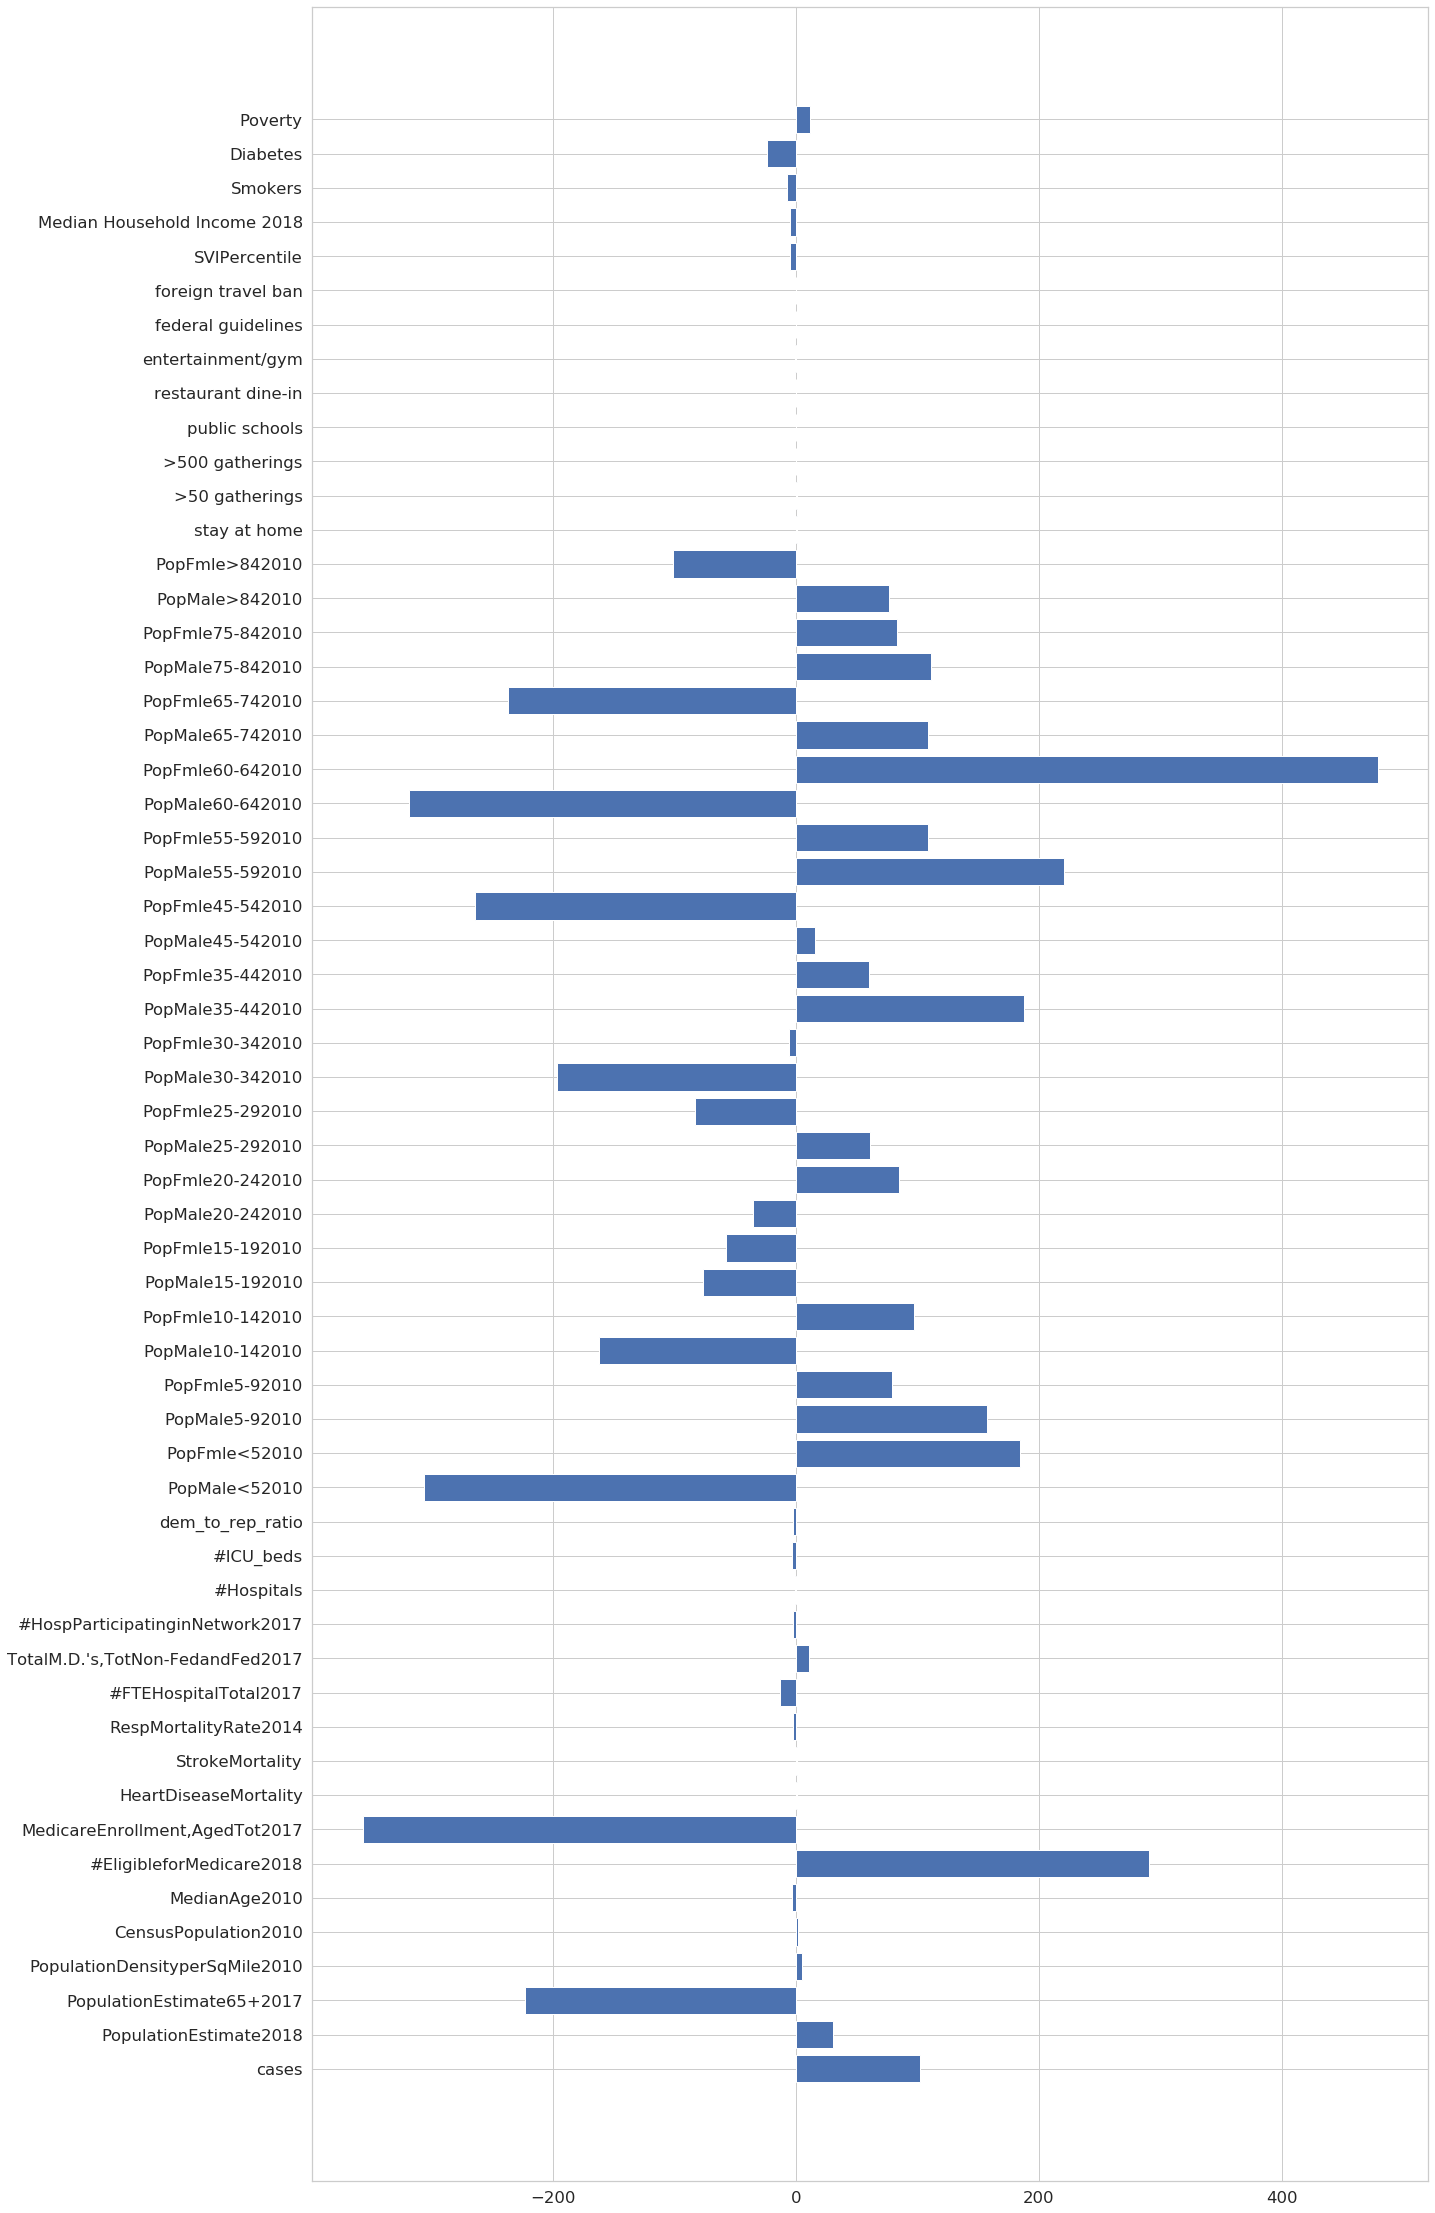

In [1014]:
fig, ax = plt.subplots(figsize=(20, 40))

plt.barh([x for x in X_col], importance)

plt.savefig('linear.jpg')

Although this model overfits, it tells us a bit about feature importance. 

In [1015]:
models['linear'] = lin_model

## 2.2 Ridge regularization

In [1016]:
ridge_model = Pipeline([
    ("SelectColumns", ColumnTransformer([
            ("keep", StandardScaler(), X_col),
        ])),
        ("LinearModel", Ridge(alpha=0.5
                             ))
    ])

In [1017]:
ridge_model.fit(train, Y_train)

Pipeline(memory=None,
         steps=[('SelectColumns',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('keep',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['cases',
                                                   'PopulationEstimate2018',
                                                   'PopulationEstimate65+2017',
                                                   'PopulationDensityperSqMile2010',
                                                   'CensusPopulation2010',
                                                   'MedianAge2010',
                   

In [1018]:
print("Training Error (RMSE):", rmse(Y_train, ridge_model.predict(train)))
print('CV Error:', np.mean(cross_val_score(ridge_model, train, Y_train, scoring=rmse_score, cv=5)))

Training Error (RMSE): 28.976104724276492
CV Error: 38.022584230068695


Alpha value of 0.5 still makes it overfit. Let us try to find the best alpha value

In [1019]:
models['ridge'] = ridge_model

In [1020]:
best_ridge = Pipeline([
    ("SelectColumns", ColumnTransformer([
            ("keep", StandardScaler(), X_col),
        ])),
        ("LinearModel", Ridge(alpha=0.5
                             ))
    ])

In [1021]:
alphas = np.linspace(10, 80, 80)
cv_values = []
train_values = []
test_values = []
for alpha in alphas:
    best_ridge.set_params(LinearModel__alpha=alpha)
    best_ridge.fit(train, Y_train)
    cv_values.append(np.mean(cross_val_score(best_ridge, train, Y_train, scoring=rmse_score, cv=5)))
    train_values.append(rmse_score(best_ridge, train, Y_train))

In [1022]:
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import cufflinks as cf
import os
cf.set_config_file(offline=True, sharing=False, theme='ggplot');

In [1023]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = alphas, y = train_values, mode="lines+markers", name="Train"))
fig.add_trace(go.Scatter(x = alphas, y = cv_values, mode="lines+markers", name="CV"))
fig.update_layout(title = 'Train and CV RMSE', xaxis_title=r"$\alpha$", yaxis_title="CV RMSE")

In [1024]:
best_alpha = alphas[np.argmin(cv_values)]
best_alpha

38.35443037974683

In [1025]:
models["best ridge"] = best_ridge

In [1026]:
print("Training Error (RMSE):", rmse(Y_train, best_ridge.predict(train)))
print('CV Error:', np.mean(cross_val_score(best_ridge, train, Y_train, scoring=rmse_score, cv=5)))

Training Error (RMSE): 34.320935210770855
CV Error: 37.80129612966338


The best ridge model doens't overfit

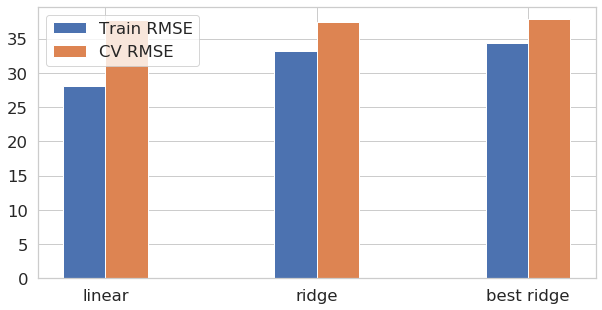

In [1027]:
ridge_model.set_params(LinearModel__alpha=best_alpha)
ridge_model.fit(train, Y_train)
compare_models(models)

## 2.3 Lasso Regularization
Lasso is  good for selecting features

In [1028]:
from sklearn.linear_model import Lasso, LassoCV

In [1029]:
lasso_model = Pipeline([
    ("SelectColumns", ColumnTransformer([
        ("keep", StandardScaler(), X_col)
    ])),
    ("LinearModel", Lasso())
])

/srv/conda/envs/data100/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning:

Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.



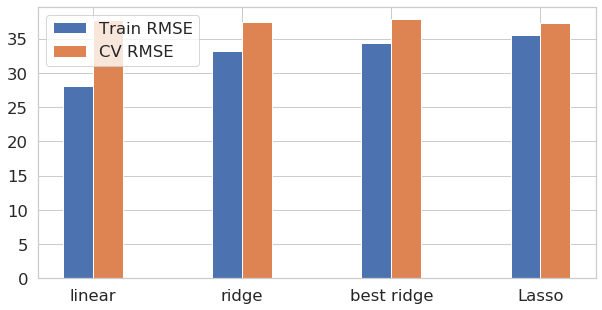

In [1030]:
lasso_model.fit(X_train, Y_train)
models["Lasso"] = lasso_model
compare_models(models)

In [1031]:
print("Training Error (RMSE):", rmse(Y_train, lasso_model.predict(train)))
print('CV Error:', np.mean(cross_val_score(lasso_model, train, Y_train, scoring=rmse_score, cv=5)))

Training Error (RMSE): 35.58686436138654
CV Error: 37.320070922968426


/srv/conda/envs/data100/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning:

Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.



## 2.4 find good features -- Use Lasso bc it's good to find features

In [1032]:
ct = models['Lasso']['SelectColumns']
feature_names = np.array(X_col)

In [1033]:
coeffs = models['Lasso']["LinearModel"].coef_
coeffs

array([101.67012384,   0.        ,   0.        ,   3.71782894,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.75176975,   0.        ,  -0.        ,  -0.        ,
        -0.        ,  -0.        ,  -0.        ,  -0.        ,
        -0.        ,  -0.        ,  -0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  -0.        ,  -0.        , -32.68439801,
        -0.        ,  -0.        ,  -0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  19.65500777,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   3.82318644,
         5.20437586,  -0.        ,   0.        ,   0.        ,
        -0.        ,  -0.        ,  -0.        ,   0.        ,
         0.        ,  -0.        ,   0.        ,   0.        ,
         0.        ,   0.        ])

In [1034]:
kept = ~np.isclose(models['Lasso']["LinearModel"].coef_, 0)
good_feature = feature_names[kept]
good_feature

array(['cases', 'PopulationDensityperSqMile2010', 'HeartDiseaseMortality',
       'PopMale25-292010', 'PopMale55-592010', 'PopMale>842010',
       'PopFmle>842010'], dtype='<U32')

These features are probably good for estimating death counts

In [1035]:
good_coef = np.array([101.67012384, 3.71782894,0.75176975,-32.68439801,19.65500777,3.82318644,5.20437586])

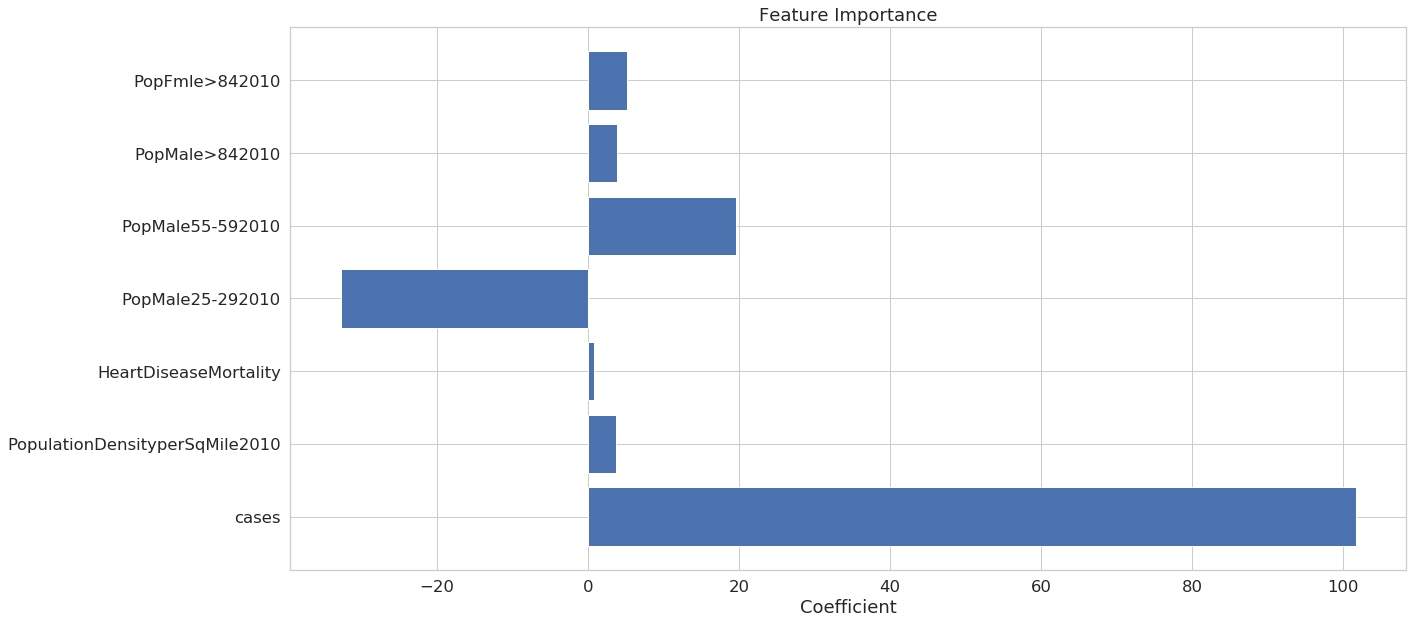

In [1036]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.barh([x for x in good_feature], good_coef)

plt.xlabel('Coefficient')
plt.title('Feature Importance')

plt.savefig('Lasso.jpg')

The features with coefficients that are not close to 0 are the features that are important in estimating death numbers due to Covid-19. We see that population of both male and female older than 84, population of male between 55-59 years old, population of male between 25-29 years old, people who died of heart disease, population density, and confirmed cases are the most important features in estimating deaths. We see that there is a very strong positive relationship between number of confirmed cases and number of deaths, and there is a positive relationship between the number of older people and number of deaths while there is a negative relationship between the number of young people and deaths. We also see a positive relationship between the number of deaths in covid and population density & heart disease mortality. 


# 3 Testing models on the Test set

In [1037]:
print('RMSE of test set on Lasso:', rmse_score(lasso_model, test, Y_test))
print('RMSE of test set on Ridge:', rmse_score(ridge_model, test, Y_test))
print('RMSE of test set without regularization:', rmse_score(lin_model, test, Y_test))

RMSE of test set on Lasso: 28.019447991905448
RMSE of test set on Ridge: 27.984900460096153
RMSE of test set without regularization: 35.39974311615905


/srv/conda/envs/data100/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning:

Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.



/srv/conda/envs/data100/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning:

Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.



Text(0.5, 0, 'RMSE of differnet models on testing set')

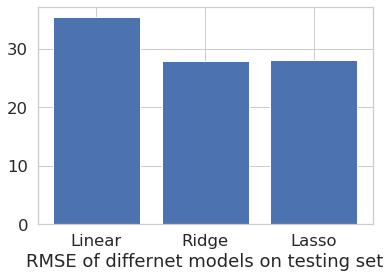

In [1038]:
models = ['Linear', 'Ridge', 'Lasso']
RMSEs = [rmse_score(lin_model, test, Y_test), rmse_score(ridge_model, test, Y_test), rmse_score(lasso_model, test, Y_test)]

plt.bar(models,RMSEs)
plt.xlabel('RMSE of differnet models on testing set')

Then, we use our Lasso model on the testing set and get a RMSE of 28.02. To further justify the use of the Lasso model, we also use the ridge model and the linear model without regularization on the testing set. The ridge model gives us a RMSE of 27.98, which is very close to the result of the Lasso model. The linear model without regularization gives us a RMSE of 35.39, which again proves that this model overfits and justifies the use of regularization.
